### **Weighing topics**:

<center>

![divided_trace.png](weighing_logs.png)

</center>

In the last notebook, we have built a transformation of the data based on clustering. With this approach, we avoid to work with the semantic part of the log and we prefer to focus our analysis on the similarity between the logs based on their main topic. 

Before developing the main idea of this file, let's put an idea on record: is the position within a trace important? We are going to divided a trace in 3 arbitrary parts: 

![divided_trace.png](divided_trace.png)

- (1) **Initial Zone**: Composed of logs related to the stat of a process. It is expected that no error related logs will appear in this part.
- (2) **Mid Zone**: It is our zone of interest. Certain logs are expected to appear that warn that trace has problems. The idea is that the logs that satisfy this condition have their predominant topic close to (or the same as...) the logs that are directly associated with error.
- (3) **Critical Zone**: Logs appearing in this area are expected to have a direct relationship to the error in the trace. We can use this info to characterise our logs.

Finally, let's see some info related to our data.

#### Trace Size:

Let's take a look at the variability in trace lengths.



List with topics-per-log loaded from TopicsPerLog/TPL_7_27082023_(0).pkl


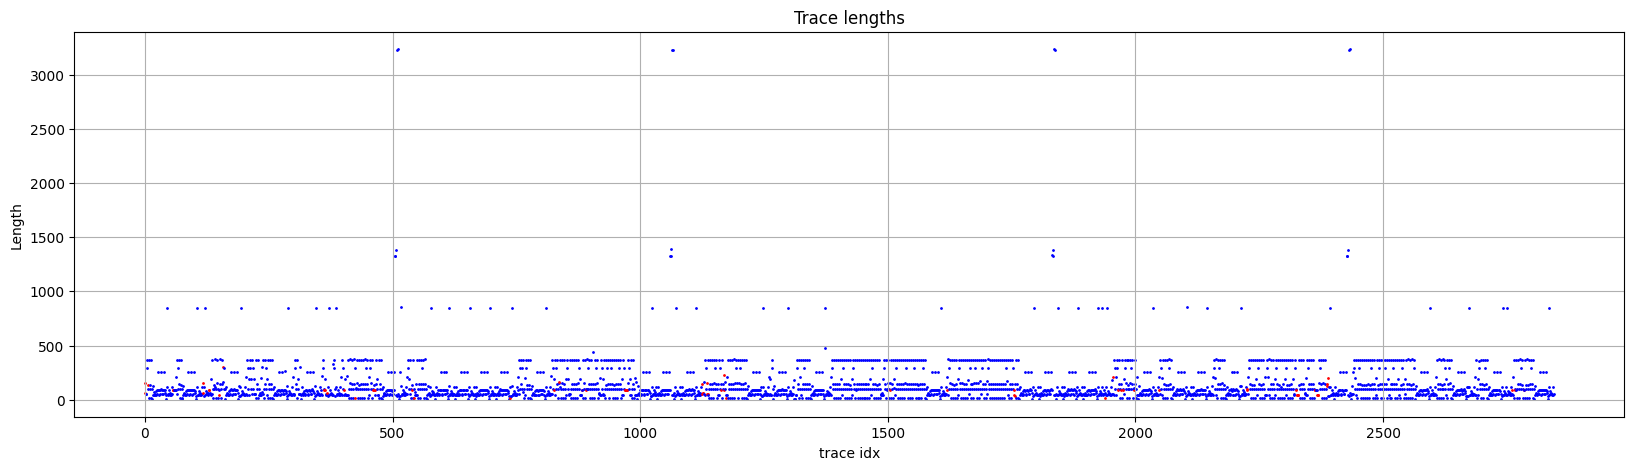

In [2]:
from functions import *
import numpy as np
import matplotlib.pyplot as plt

num_topics=7
topics=  load_topic_list(num_topics=num_topics) 

#data
ds= TplPionier(config=config.ds_medium)
errors_idx=list(ds.index[ds.index['ERROR'] == True].index)

#calculate the trace size
lengths = [len(trace) for trace in topics]
plt.figure(figsize=(20, 5)) 

for i in range(len(topics)):
    color = 'red' if i in errors_idx else 'blue'
    plt.scatter(i, lengths[i], color=color, s=1) #

plt.title('Trace lengths')
plt.xlabel('trace idx')
plt.ylabel('Length')
plt.grid()
plt.show()

It can be noted that the vast majority of the traces do not exceed the length of 500. However, some of them can exceed a length of 3000. Regarding the lengths of the error traces (red points), the graph is not entirely conclusive, so let's look deeper...

#### Error Traces Size

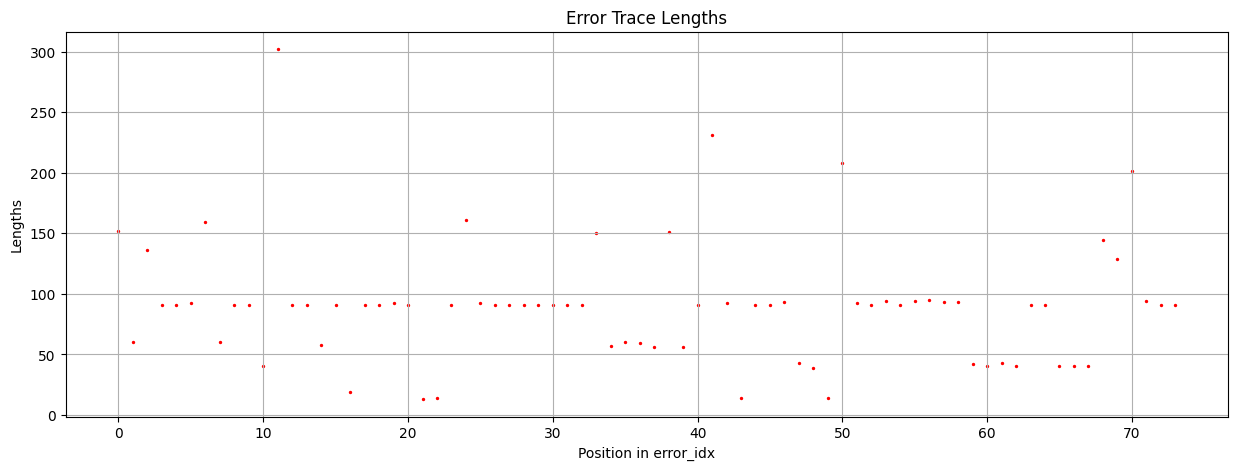

In [3]:
plt.figure(figsize=(15, 5))  
plt.scatter(range(len(errors_idx)), [lengths[j] for j in errors_idx], color='red', s=2)
plt.title('Error Trace Lengths')
plt.xlabel('Position in error_idx')
plt.ylabel('Lengths')
plt.grid()
plt.show()

It can be noted that most of the error traces do not exceed a length of 100, but some of them can exceed a length of 150 and even exceed 200.

#### Length frequencies:

Let's look at the frequencies of trace lengths:

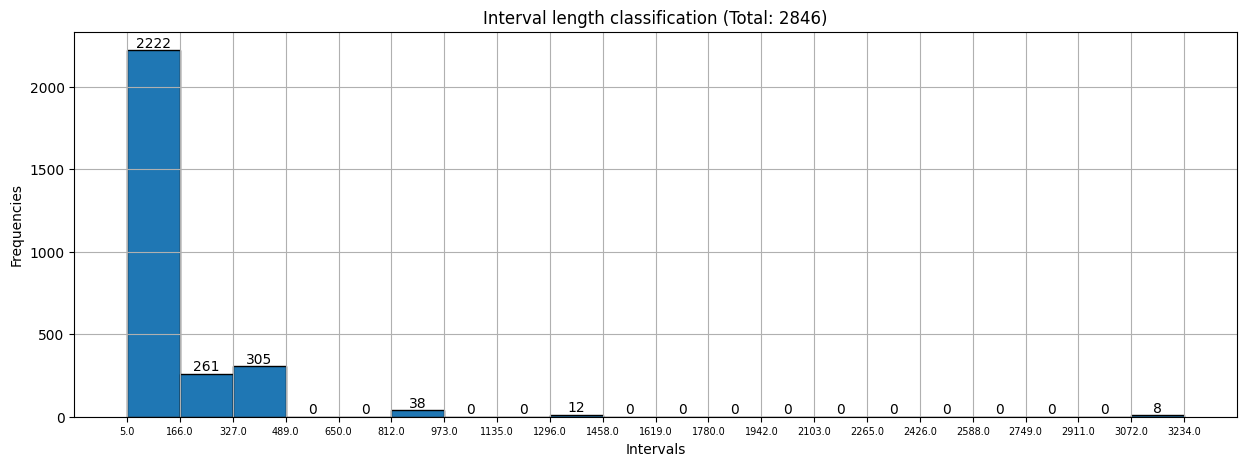

In [4]:
# We classify the lengths into 20 intervals:
histogram = np.histogram(lengths, bins=20)
frequencies, interval_limits = histogram

# plotting
plt.figure(figsize=(15, 5))
plt.bar(interval_limits[:-1], frequencies, width=np.diff(interval_limits), align='edge', edgecolor='black')

labels = [f'{ np.trunc(interval_limits[i])}' for i in range(len(interval_limits) )]
plt.xticks(interval_limits, labels, fontsize=7)

for i, freq in enumerate(frequencies):
    plt.text(interval_limits[i] + np.diff(interval_limits)[i] / 2, freq + 0.1, str(freq),
             ha='center', va='bottom')

# Personalizar el gráfico
plt.title(f'Interval length classification (Total: {len(lengths)})')
plt.xlabel('Intervals')
plt.ylabel('Frequencies')
plt.grid()

plt.show()

We can clearly see how the vast majority of our traces are in the range: 5-166. In addition, the rest are in the range: 327-489 (305) and 166-327 (261). Almost as an outlier, we have 8 traces in the range: 3072-3234. Let's look at the behavior of the traces with error.

#### Error Length Frequencies

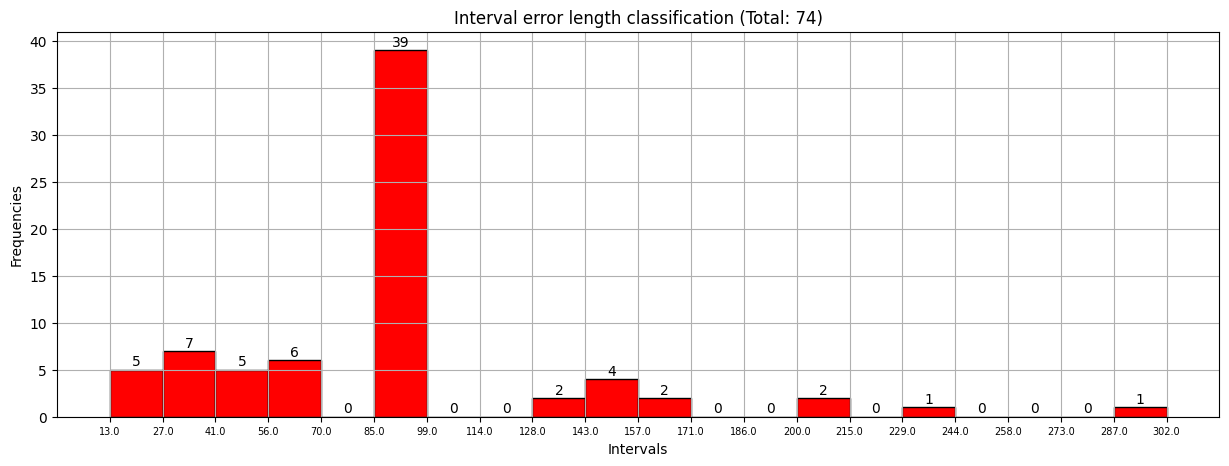

In [5]:
error_lengths=[lengths[j] for j in errors_idx]
histogram = np.histogram(error_lengths, bins=20)
frequencies, interval_limits = histogram 

plt.figure(figsize=(15, 5))
plt.bar(interval_limits[:-1], frequencies, width=np.diff(interval_limits), align='edge', edgecolor='black', color='red')

etiquetas = [f'{ np.trunc(interval_limits[i])}' for i in range(len(interval_limits) )]
plt.xticks(interval_limits, etiquetas, fontsize=7)

for i, freq in enumerate(frequencies):
    plt.text(interval_limits[i] + np.diff(interval_limits)[i] / 2, freq + 0.1, str(freq),
             ha='center', va='bottom')

# Personalizar el gráfico
plt.title(f'Interval error length classification (Total: {len(error_lengths)})')
plt.xlabel('Intervals')
plt.ylabel('Frequencies')
plt.grid()

plt.show()

For error traces, we have previously seen that the maximun recorded length is 300. However, more than half of the lengths are in the 85-99 range and, in general, the vast majority of the traces do not exceed length 100. This may be important if we would like to establish a break point within the trace, on which our model decides whether it is a traces with error or not.

#### Appearance of traces error:

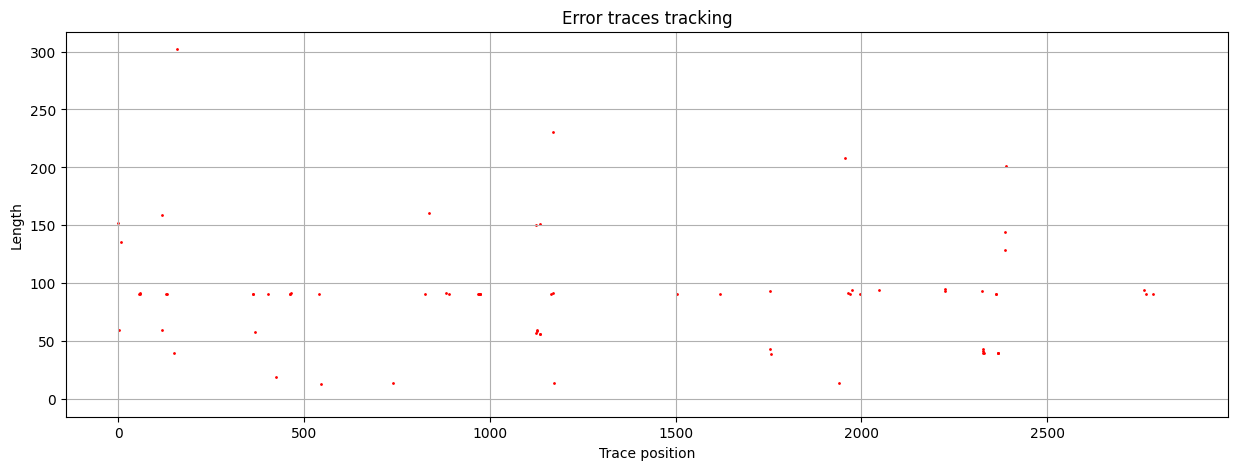

In [6]:
error_tracking = [numero if i in errors_idx else 0 for i, numero in enumerate(lengths)]

plt.figure(figsize=(15, 5)) 

# It is very slow
for i in range(len(error_tracking)):
    color = 'white' if error_tracking[i] == 0 else 'red'
    plt.scatter(i, error_tracking[i], color=color, s=1) #

plt.title('Error traces tracking')
plt.xlabel('Trace position')
plt.ylabel('Length')
plt.grid()
plt.show()

#### Frequencies of the predominant topics:

Número 0: 272761 times
Número 5: 55522 times
Número 3: 17967 times
Número 2: 1532 times
Número 1: 48851 times
Número 6: 12803 times
Número 4: 4765 times


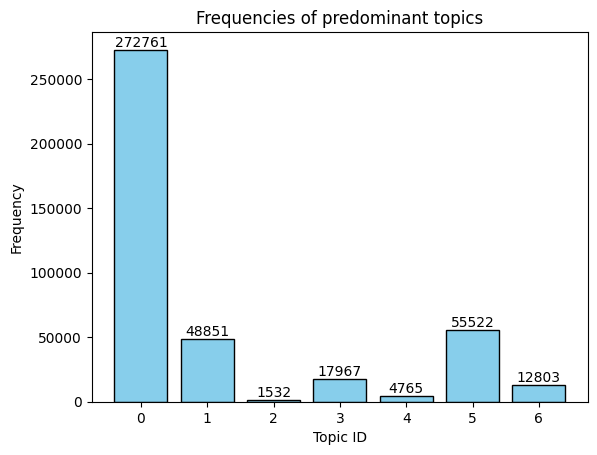

In [7]:
from collections import Counter

# Using Counter to count the frequency of each topic 
freq_topics = Counter(num for trace in topics for num in trace)

for num, freq in freq_topics.items():
    print(f"Número {num}: {freq} times")


# Extract the numbers and frequencies
num, freq = zip(*freq_topics.items())

plt.bar(num, freq, color='skyblue', edgecolor='black')
plt.xlabel('Topic ID')
plt.ylabel('Frequency')
plt.title('Frequencies of predominant topics')
for num, freq in zip(num, freq):
    plt.text(num, freq + 0.1, str(freq), ha='center', va='bottom')
plt.show()

Número 0: 1251 times
Número 5: 4776 times
Número 3: 226 times
Número 2: 326 times
Número 1: 48 times
Número 6: 17 times


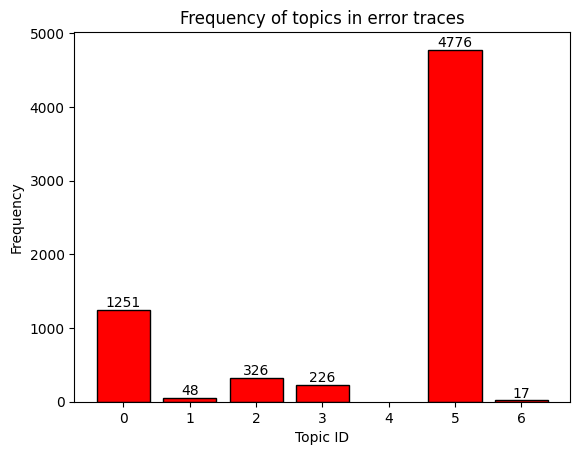

In [8]:
#topics in error traces
error_topics = [topics[j] for j in errors_idx]
#Frequency of topics in error traces
freq_error_topics = Counter(num for error_trace in error_topics for num in error_trace)
for num, freq in freq_error_topics.items():
    print(f"Número {num}: {freq} times")

num, freq = zip(*freq_error_topics.items())
plt.bar(num, freq, color='red', edgecolor='black')
plt.xlabel('Topic ID')
plt.ylabel('Frequency')
plt.title('Frequency of topics in error traces')
for num, freq in zip(num, freq):
    plt.text(num, freq + 0.1, str(freq), ha='center', va='bottom')

plt.show()

In [9]:
def frequency_graphs(topics, ds=TplPionier(config=config.ds_medium), percentage_display=1):
    fig, (ax1,ax2,ax3)= plt.subplots(3,1, figsize=(14,10), sharex=True)

    #About predominant topic
    cut_topics=[]
    for i in range(len(topics)):
        cutting_index=int(len(topics[i]) * percentage_display)
        cut_trace= topics[i][-cutting_index:]
        cut_topics.append(cut_trace)

    freq_topics = Counter(num for trace in cut_topics for num in trace)
    num, freq = zip(*freq_topics.items())
    ax1.bar(num, freq, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Topic ID')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Frequencies of predominant topics (Cutting in the last: {percentage_display * 100} %)')
    for num, freq in zip(num, freq):
        ax1.text(num, freq + 0.1, str(freq), ha='center', va='bottom')

    #About topics in error traces
    errors_idx= list(ds.index[ds.index['ERROR'] == True].index)
    error_topics = [topics[j] for j in errors_idx]
    cut_error_topics=[]
    for i in range(len(errors_idx)):
        cutting_index=int(len(error_topics[i]) * percentage_display)
        cut_trace=error_topics[i][-cutting_index:]
        cut_error_topics.append(cut_trace)
    freq_error_topics = Counter(num for error_trace in cut_error_topics for num in error_trace)
    num, freq = zip(*freq_error_topics.items())
    ax2.bar(num, freq, color='red', edgecolor='black')
    ax2.set_xticks(num)
    ax2.set_xlabel('Topic ID')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Frequency of topics in error traces (Cutting in the last: {percentage_display * 100} %)')
    for num, freq in zip(num, freq):
        ax2.text(num, freq + 0.1, str(freq), ha='center', va='bottom')


    #About topics in non error traces
    non_error_topics = [topic for i, topic in enumerate(topics) if i not in errors_idx]
    cut_non_error_topics=[]
    for i in range(len(non_error_topics)):
        cutting_index=int(len(non_error_topics[i]) * percentage_display)
        cut_trace=non_error_topics[i][-cutting_index:]
        cut_non_error_topics.append(cut_trace)
    freq_non_error_topics = Counter(num for non_error_trace in cut_non_error_topics for num in non_error_trace)
    num, freq = zip(*freq_non_error_topics.items())
    ax3.bar(num, freq, color='blue', edgecolor='black')
    ax3.set_xticks(num)
    ax3.set_xlabel('Topic ID')
    ax3.set_ylabel('Frequency')
    ax3.set_title(f'Frequency of topics in NON error traces (Cutting in the last: {percentage_display * 100} %)')
    for num, freq in zip(num, freq):
        ax3.text(num, freq + 0.1, str(freq), ha='center', va='bottom')

    

    plt.tight_layout()
    plt.show()

List with topics-per-log loaded from TopicsPerLog/TPL_12_24112023_(0).pkl


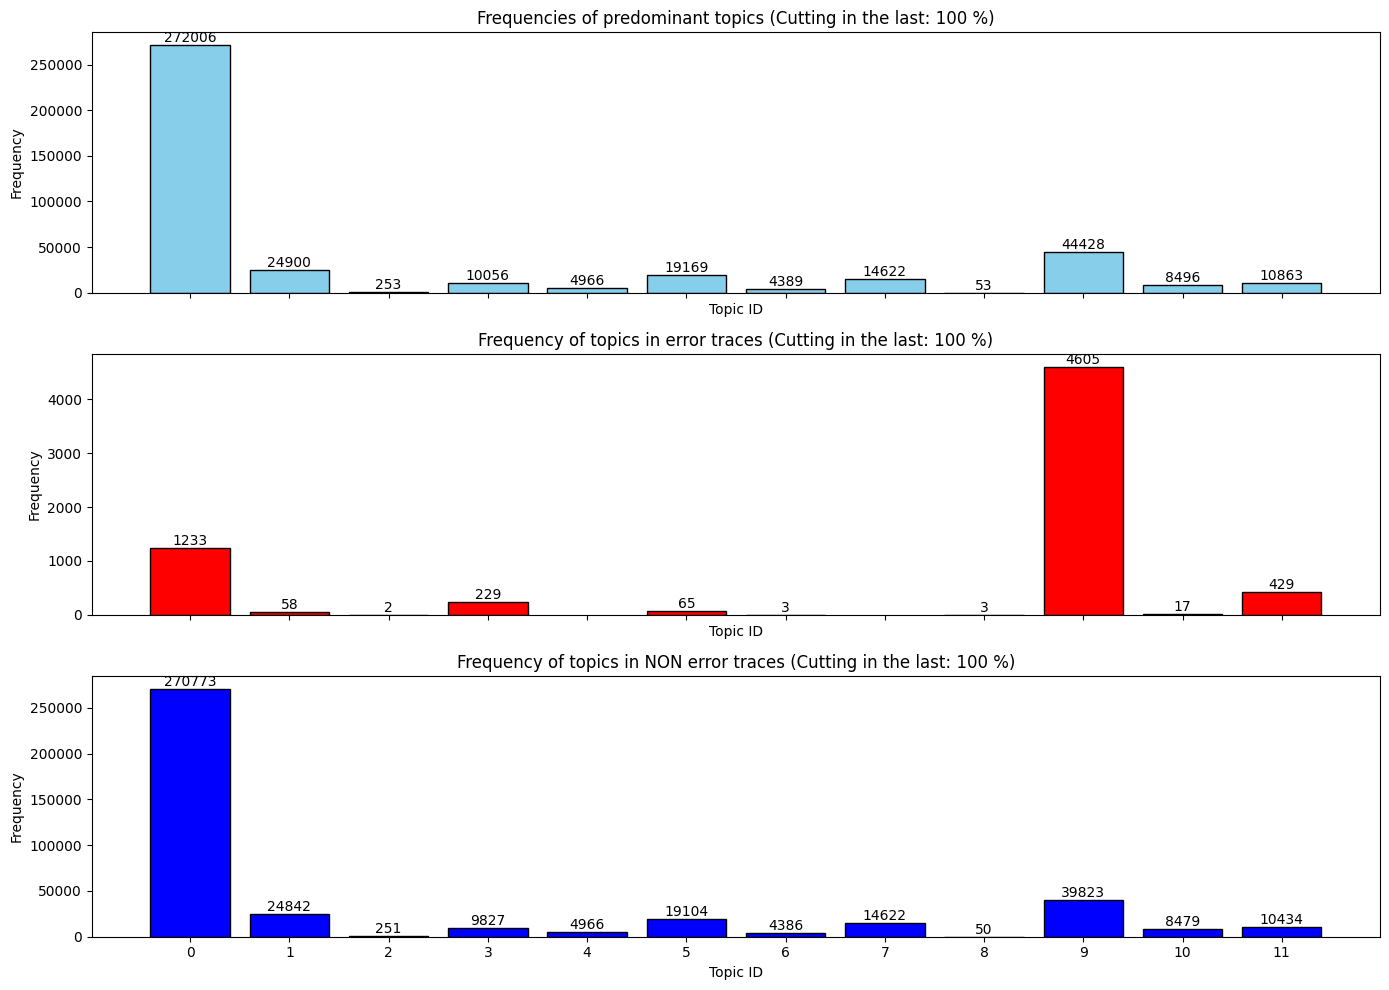

In [29]:
frequency_graphs(load_topic_list(num_topics=12), percentage_display=1 )

### Adding weight to the topics

$$ [\text{IDF-based Event Weighting}] \; w_{idf} = \log ( \dfrac{N}{n_t})$$
where $N$ is the total number of log sequences and $n_t$ is the number of sequences where the topic $t$ appears

In [11]:
import math

N= len(topics)
print(f"N: {len(topics)}, total number of log sequences-traces")

N: 2846, total number of log sequences-traces


In [12]:
n_t = {i: 0 for i in range(num_topics)}
w_idf={i: 0 for i in range(num_topics)}

for i in range(len(topics)):
    uniques=set(topics[i])
    for num in uniques: 
        n_t[num] += 1

for idx_topic in n_t:
    w_idf[idx_topic] = math.log(N/n_t[idx_topic])
    
print("n_t: ", n_t)

n_t:  {0: 2846, 1: 1834, 2: 226, 3: 1959, 4: 365, 5: 1909, 6: 1638}


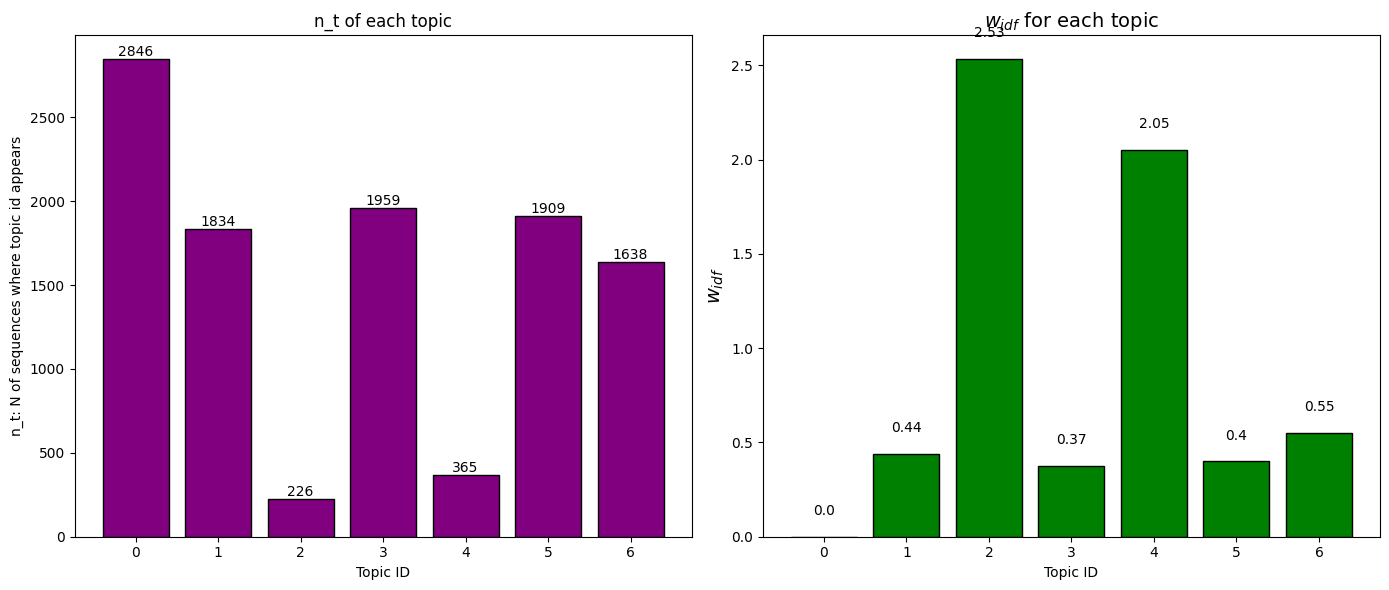

In [13]:
idx_topics=[idx for idx in list(n_t.keys())]
n_t_values=list(n_t.values())
w_idf_values=list(w_idf.values())


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.bar(idx_topics, n_t_values, color='purple', edgecolor='black')
ax1.set_xticks(idx_topics)
ax1.set_xlabel('Topic ID')
ax1.set_ylabel('n_t: N of sequences where topic id appears')
ax1.set_title('n_t of each topic')
for num, freq in zip(idx_topics, n_t_values):
    ax1.text(num, freq + 0.1, str(freq), ha='center', va='bottom')

ax2.bar(idx_topics, w_idf_values, color='green', edgecolor='black')
ax2.set_xticks(idx_topics)
ax2.set_xlabel('Topic ID')
ax2.set_ylabel(r'$w_{idf}$', fontsize=14)
ax2.set_title(r'$w_{idf}$ for each topic', fontsize=14)

for num, freq in zip(idx_topics, w_idf_values):
    ax2.text(num, freq + 0.1, round(freq,2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
def weighing_topics(num_topics):
    
    topics=  load_topic_list(num_topics=num_topics) 

    #N
    N=len(topics)
    
    n_t = {i: 0 for i in range(num_topics)}
    w_idf={i: 0 for i in range(num_topics)}

    #n_t
    for i in range(len(topics)):
        uniques=set(topics[i])
        for num in uniques: 
            n_t[num] += 1
    #w_idf
    for idx_topic in n_t:
        w_idf[idx_topic] = math.log(N/n_t[idx_topic])

    weighed_topics = [[ w_idf[topic] for topic in trace] for trace in topics]

    return n_t, w_idf, weighed_topics
    
n_t, w_idf, weighted_topics = weighing_topics(18)

List with topics-per-log loaded from TopicsPerLog/TPL_18_24112023_(0).pkl


In [15]:
def plotting_widf(n_t, w_idf):

    idx_topics=[idx for idx in list(n_t.keys())]
    n_t_values=list(n_t.values())
    w_idf_values=list(w_idf.values())


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    ax1.bar(idx_topics, n_t_values, color='purple', edgecolor='black')
    ax1.set_xticks(idx_topics)
    ax1.set_xlabel('Topic ID')
    ax1.set_ylabel('n_t: N of sequences where topic id appears')
    ax1.set_title(r'$n_{t}$ for each topic', fontsize=14)
    for numero, frecuencia in zip(idx_topics, n_t_values):
        ax1.text(numero, frecuencia + 0.1, str(frecuencia), ha='center', va='bottom')

    ax2.bar(idx_topics, w_idf_values, color='green', edgecolor='black')
    ax2.set_xticks(idx_topics)
    ax2.set_xlabel('Topic ID')
    ax2.set_ylabel(r'$w_{idf}$', fontsize=14)
    ax2.set_title(r'$w_{idf}$ for each topic', fontsize=14)

    for numero, frecuencia in zip(idx_topics, w_idf_values):
        ax2.text(numero, frecuencia + 0.1, round(frecuencia,2), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

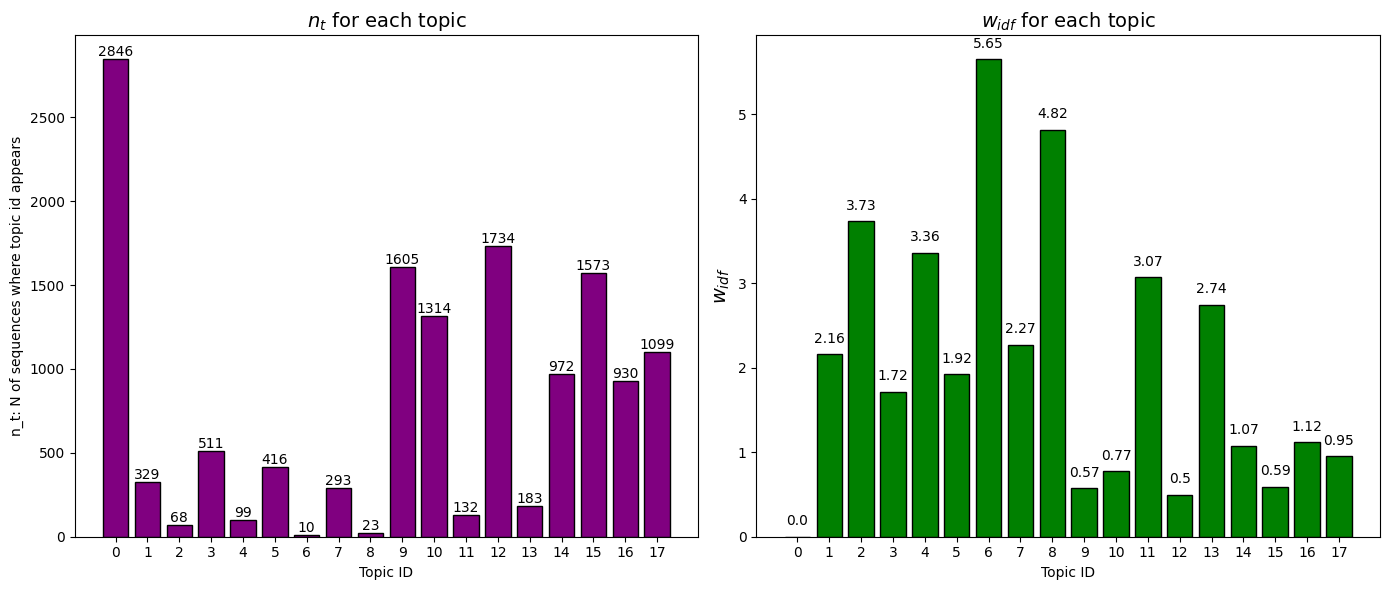

In [16]:
plotting_widf(n_t,w_idf)

$$ \text{(Relative frequency in E.T)} = \dfrac{\# \text{topic frequency}}{\text{total of logs}} $$

In [84]:
def relative_frequency(num_topics, ds=TplPionier(config=config.ds_medium), percentage_display=1):
    topics=load_topic_list(num_topics=num_topics)
    errors_idx= list(ds.index[ds.index['ERROR'] == True].index)
    error_topics = [topics[j] for j in errors_idx]
    cut_error_topics=[]
    for i in range(len(errors_idx)):
        cutting_index=int(len(error_topics[i]) * percentage_display)
        cut_trace=error_topics[i][-cutting_index:]
        cut_error_topics.append(cut_trace)
    freq_error_topics = Counter(num for error_trace in cut_error_topics for num in error_trace)
    topic_id, freq= zip(*freq_error_topics.items())
    total_error_logs= sum(freq)
    freq_relative_error_topics= {clave: valor / total_error_logs for clave, valor in zip(topic_id,freq)}

    freq_relative_topics = {i: 0 for i in range(0, num_topics)}

    freq_relative_topics.update(freq_relative_error_topics)

    weighed_topics = [[ freq_relative_topics[topic] for topic in trace] for trace in topics]
    

    return freq_relative_topics, weighed_topics

In [85]:
frequencies, weighed_topics_a=relative_frequency(12)
frequencies, weighed_topics_a

List with topics-per-log loaded from TopicsPerLog/TPL_12_24112023_(0).pkl


({0: 0.18558097531607465,
  1: 0.008729680915111379,
  2: 0.00030102347983142685,
  3: 0.034467188440698376,
  4: 0,
  5: 0.009783263094521372,
  6: 0.0004515352197471403,
  7: 0,
  8: 0.0004515352197471403,
  9: 0.6931065623118603,
  10: 0.0025586995785671285,
  11: 0.06456953642384106},
 [[0.18558097531607465,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.6931065623118603,
   0.69310656231186